In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100
sns.set_style('white')
def show_several(df):
    for j in df.index:
        print(j)
        show_one(j)
def show_one(j):
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

Using Theano backend.


In [3]:
db = load_db()
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
    for k, v in j['stats'].items():
        col[k] = v
        if type(v) is dict:
            for kk, v in v.items():
                col[kk]=v
    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    
    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    #if 'digits_entropy' not in col:
    #    print(j['summary'])
    #if 'digits_count' not in col:
    #    continue
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    col['digits_object'] = 1 - col['digits_entropy']
    col['letters_object'] = 1 - col['letters_entropy']
    col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    col['emnist_object'] = 1 - col['emnist_letters_entropy']
    del col['recons_ratio']
    del col['metrics']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full['in_score'] =  df_full['emnist_digits_count'] + 5*df_full['emnist_object'] + 10*df_full['digits_diversity']
df_full['out_score'] =  df_full['emnist_letters_count'] + 5*df_full['emnist_object'] + 10*df_full['letters_diversity']
df_full.to_csv('hypers.csv')

In [72]:
df_full = pd.read_csv('hypers.csv').set_index('id')

## Fix stride. vary nb of layers

In [73]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,digits_test,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,hwrt_thin,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,ratio_unique,recons,sampler,stride,zero_ratio,in_score,out_score,innovative,existing,noisy,y
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9e80faae4fb4ae36b2766648824eac09,128.0,0.0000,0.116791,0.883209,12.550046,0.086,0.800376,0.191304,6.500855e+07,0.078,0.002076,0.808696,4.151053,NaN,0.018,0.013,0.757,0.352276,0.141,0.647724,5.123708,0.0000,0.522073,0.082004,14.290085,NaN,0.848,0.810578,0.347885,1.427359e+08,0.501,0.002082,0.652115,5.316375,1,6529.0,NaN,0.066,0.967,NaN,mnist_deep,2.0,NaN,11.260383,12.101395,0,0,1,-0.015197
68adffea6c98fedf329644122d56fa36,128.0,0.9847,0.039539,0.960461,19.538910,0.577,0.911845,0.087772,6.482822e+07,0.517,0.002000,0.912228,6.700230,NaN,0.090,0.080,0.568,0.248701,0.173,0.751299,13.314023,0.5403,0.788424,0.112240,57.670715,NaN,0.365,0.926126,0.116562,1.426116e+08,0.316,0.002006,0.883438,14.033784,2,825985.0,NaN,0.058,1.000,NaN,mnist_deep,2.0,NaN,12.964945,13.585753,1,0,0,0.750644
901dad8ec11f23191d86fa6279d47c65,128.0,0.9959,0.031575,0.968425,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002000,0.915515,6.845440,NaN,0.108,0.096,0.482,0.246643,0.154,0.753357,12.352144,0.6943,0.765771,0.100727,52.514980,NaN,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,0.889532,14.415942,3,1645441.0,NaN,0.043,1.000,NaN,mnist_deep,2.0,NaN,13.028350,13.519402,1,0,0,0.812460
63c1be88f742117d115d076216ac85d1,128.0,0.9992,0.020904,0.979096,10.919588,0.849,0.916866,0.055326,6.480193e+07,0.794,0.002000,0.944674,7.269512,NaN,0.130,0.121,0.440,0.208254,0.196,0.791746,10.687059,0.6233,0.676443,0.095547,33.215351,NaN,0.124,0.778797,0.088160,1.426905e+08,0.113,0.002006,0.911840,9.548794,4,2464897.0,NaN,0.027,1.000,NaN,mnist_deep,2.0,NaN,13.257390,12.186700,0,1,0,0.351087
581582abec259852f4a01f7e79ed97db,128.0,0.9816,0.020118,0.979882,7.382170,0.964,0.851105,0.056269,6.483472e+07,0.886,0.002008,0.943731,6.220617,NaN,0.128,0.122,0.458,0.212822,0.178,0.787178,8.264774,0.1854,0.614825,0.109743,22.542377,NaN,0.024,0.767487,0.096898,1.427642e+08,0.021,0.002014,0.903102,9.044111,5,3284353.0,NaN,0.012,0.996,NaN,mnist_deep,2.0,NaN,12.574943,12.068761,0,1,0,0.058374
8ecaf99d22cf4cb469912b9fae25aac2,128.0,0.5753,0.008583,0.991417,4.169066,0.998,0.630844,0.042352,6.493132e+07,0.967,0.005644,0.957648,3.949130,NaN,0.098,0.093,0.331,0.196629,0.108,0.803371,5.691341,0.0206,0.426911,0.099368,8.652865,NaN,0.001,0.602850,0.086963,1.428706e+08,0.001,0.005650,0.913037,5.471218,6,4103809.0,NaN,0.001,0.593,NaN,mnist_deep,2.0,NaN,10.423301,10.376358,0,1,0,-0.014136


## Fix nb layers. Vary stride

In [333]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,digits_test,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,hwrt_thin,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5511413bb44248b61f32518f638a8d9e,128.0,1.0000,0.043103,0.956897,15.068205,0.712,0.912121,0.109552,6.482374e+07,0.621,0.002,0.890448,6.414445,NaN,0.031,0.029,0.694,0.310742,0.131,0.689258,8.729666,0.9966,0.646863,0.100108,26.331829,NaN,0.231,0.917145,0.121261,1.426300e+08,0.193,0.002006,0.878739,13.536750,3,1645441.0,NaN,0.057,1.0,NaN,mnist_deep,0.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,1.0000,0.031410,0.968590,14.714568,0.773,0.924139,0.083757,6.478472e+07,0.713,0.002,0.916243,6.948976,NaN,0.081,0.073,0.572,0.254680,0.178,0.745320,12.290185,0.9722,0.775435,0.104893,55.180447,NaN,0.172,0.926554,0.101766,1.426092e+08,0.153,0.002006,0.898234,14.877086,3,1645441.0,NaN,0.055,1.0,NaN,mnist_deep,1.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.9959,0.031575,0.968425,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002,0.915515,6.845440,NaN,0.108,0.096,0.482,0.246643,0.154,0.753357,12.352144,0.6943,0.765771,0.100727,52.514980,NaN,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,0.889532,14.415942,3,1645441.0,NaN,0.043,1.0,NaN,mnist_deep,2.0,NaN
60168f92bfbc6331027b213e2e9d4f6f,128.0,0.9713,0.034976,0.965024,13.157985,0.771,0.937145,0.083086,6.482572e+07,0.694,0.002,0.916914,7.141914,NaN,0.122,0.109,0.453,0.245890,0.142,0.754110,10.135502,0.3448,0.757821,0.114442,47.322350,NaN,0.179,0.877613,0.115620,1.426912e+08,0.157,0.002006,0.884380,12.196813,3,1645441.0,NaN,0.050,1.0,NaN,mnist_deep,4.0,NaN


## wta kchannel

In [334]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,digits_test,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,hwrt_thin,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86edda1cd4ca18d86af1d30a3691743c,128.0,0.0001,0.080477,0.919523,17.730999,0.155,0.831264,0.163009,6.493536e+07,0.133,0.002000,0.836991,4.641634,NaN,0.031,0.030,0.761,0.286676,0.197,0.713324,6.872862,0.0000,0.595692,0.084899,21.616522,NaN,0.751,0.874809,0.216747,1.426393e+08,0.559,0.002006,0.783253,8.915785,1,6529.0,NaN,0.094,1.000,NaN,mnist_deep_kchannel,NaN,0.9
e2a3cf325e945c1a0be38073933f5938,128.0,0.7410,0.051193,0.948807,20.280416,0.509,0.922437,0.105584,6.486263e+07,0.438,0.002000,0.894416,6.592316,NaN,0.082,0.074,0.580,0.259248,0.167,0.740752,11.651826,0.1328,0.780166,0.112815,52.920902,NaN,0.426,0.935885,0.134873,1.426424e+08,0.347,0.002006,0.865127,13.841786,2,825985.0,NaN,0.065,1.000,NaN,mnist_deep_kchannel,NaN,0.9
876bbdc0501b9e043d5e566bc13f6a5a,128.0,0.9927,0.036674,0.963326,14.189510,0.693,0.921693,0.077887,6.480994e+07,0.636,0.002000,0.922113,7.004585,NaN,0.125,0.113,0.425,0.238127,0.164,0.761873,11.007601,0.4695,0.729812,0.097576,43.878284,NaN,0.251,0.890408,0.114385,1.426517e+08,0.211,0.002006,0.885615,12.584548,3,1645441.0,NaN,0.056,1.000,NaN,mnist_deep_kchannel,NaN,0.9
e72e79bf4cd53875e7ec8784a64b45ce,128.0,0.9872,0.035782,0.964218,13.253835,0.797,0.962560,0.097950,6.485025e+07,0.715,0.002012,0.902050,7.298103,NaN,0.097,0.091,0.501,0.271282,0.128,0.728718,11.336662,0.2639,0.736383,0.112633,42.219612,NaN,0.157,0.860804,0.093629,1.427092e+08,0.136,0.002018,0.906371,12.298592,4,2464897.0,NaN,0.046,0.995,NaN,mnist_deep_kchannel,NaN,0.9
40b4aa2f3f994823faf01e804567b430,128.0,0.9944,0.027230,0.972770,10.462719,0.878,0.912284,0.068199,6.482983e+07,0.803,0.002004,0.931801,7.043870,NaN,0.136,0.126,0.414,0.242237,0.135,0.757763,10.329323,0.2969,0.701115,0.124744,32.360668,NaN,0.090,0.817857,0.097824,1.427340e+08,0.079,0.002010,0.902176,10.536287,5,3284353.0,NaN,0.032,0.998,NaN,mnist_deep_kchannel,NaN,0.9
bb8051dece1c1d1c64b96ec2a6e53179,128.0,0.9883,0.015016,0.984984,6.574772,0.945,0.741461,0.036610,6.492172e+07,0.904,0.007648,0.963390,5.054827,NaN,0.214,0.209,0.544,0.152843,0.311,0.847157,9.197904,0.1790,0.635446,0.132672,23.531170,NaN,0.033,0.675831,0.073278,1.428226e+08,0.033,0.007654,0.926722,7.549600,6,4103809.0,NaN,0.022,0.689,NaN,mnist_deep_kchannel,NaN,0.9


In [335]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,digits_test,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,hwrt_thin,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ea5a6d5f06f610e42a7758d016f30631,128.0,1.0000,0.033526,0.966474,10.267786,0.886,0.928558,0.096455,6.481865e+07,0.784,0.002000,0.903545,6.836795,NaN,0.050,0.047,0.613,0.293138,0.126,0.706862,8.653771,0.9621,0.696288,0.105167,34.773663,NaN,0.078,0.875678,0.120396,1.426743e+08,0.067,0.002006,0.879604,11.842268,4,2464897.0,NaN,0.036,1.000,NaN,mnist_deep_kchannel,NaN,0.1
97f848a3659016b169c3b778f6443df6,128.0,1.0000,0.035800,0.964200,10.734946,0.879,0.910082,0.101740,6.481725e+07,0.771,0.002000,0.898260,6.512172,NaN,0.047,0.045,0.649,0.288722,0.162,0.711278,9.695365,0.9611,0.742858,0.115580,43.253986,NaN,0.076,0.900592,0.108631,1.426643e+08,0.065,0.002006,0.891369,13.210104,4,2464897.0,NaN,0.045,1.000,NaN,mnist_deep_kchannel,NaN,0.2
839e0040c4d7dc9d76c78641b6f7c123,128.0,1.0000,0.037973,0.962027,11.772392,0.813,0.927844,0.098415,6.481135e+07,0.723,0.002000,0.901585,6.729656,NaN,0.044,0.040,0.612,0.282900,0.159,0.717100,9.802176,0.9484,0.691784,0.104327,35.250458,NaN,0.126,0.854306,0.105794,1.426486e+08,0.111,0.002006,0.894206,11.610181,4,2464897.0,NaN,0.061,1.000,NaN,mnist_deep_kchannel,NaN,0.4
2afff129f2d57b51af6a55d4fe53c1f1,128.0,1.0000,0.034595,0.965405,10.692108,0.876,0.923574,0.096244,6.481855e+07,0.773,0.002000,0.903756,6.803250,NaN,0.077,0.069,0.549,0.269395,0.156,0.730605,9.723644,0.9204,0.755191,0.109524,48.730453,NaN,0.094,0.841312,0.106257,1.426749e+08,0.080,0.002006,0.893743,11.116551,4,2464897.0,NaN,0.030,1.000,NaN,mnist_deep_kchannel,NaN,0.5
414122cb7ccc4a125385d75e5c0eb585,128.0,1.0000,0.034061,0.965939,12.497256,0.804,0.923587,0.097247,6.480683e+07,0.723,0.002000,0.902753,6.797603,NaN,0.076,0.065,0.571,0.273740,0.163,0.726260,10.970304,0.8590,0.770649,0.105082,53.092396,NaN,0.153,0.854546,0.096067,1.426501e+08,0.128,0.002006,0.903933,11.954018,4,2464897.0,NaN,0.043,1.000,NaN,mnist_deep_kchannel,NaN,0.7
e72e79bf4cd53875e7ec8784a64b45ce,128.0,0.9872,0.035782,0.964218,13.253835,0.797,0.962560,0.097950,6.485025e+07,0.715,0.002012,0.902050,7.298103,NaN,0.097,0.091,0.501,0.271282,0.128,0.728718,11.336662,0.2639,0.736383,0.112633,42.219612,NaN,0.157,0.860804,0.093629,1.427092e+08,0.136,0.002018,0.906371,12.298592,4,2464897.0,NaN,0.046,0.995,NaN,mnist_deep_kchannel,NaN,0.9


In [53]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)

In [337]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]

In [338]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
#show(d.iloc[0:10])

In [54]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'ratio_unique',
    'y',
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,ratio_unique,y
digits_count,1,-0.889549,0.514348,0.397584,-0.0120687,0.485708,0.249662,0.372779
letters_count,-0.889549,1,-0.410713,-0.291146,0.109984,-0.385495,-0.128651,-0.362347
digits_objectness,0.514348,-0.410713,1,0.913232,0.677031,0.955648,0.898425,0.668014
letters_objectness,0.397584,-0.291146,0.913232,1,0.818102,0.943213,0.880558,0.766922
digits_and_letters_objectness,-0.0120687,0.109984,0.677031,0.818102,1,0.701271,0.817205,0.514532
emnist_objectness,0.485708,-0.385495,0.955648,0.943213,0.701271,1,0.863067,0.728093
ratio_unique,0.249662,-0.128651,0.898425,0.880558,0.817205,0.863067,1,0.53693
y,0.372779,-0.362347,0.668014,0.766922,0.514532,0.728093,0.53693,1


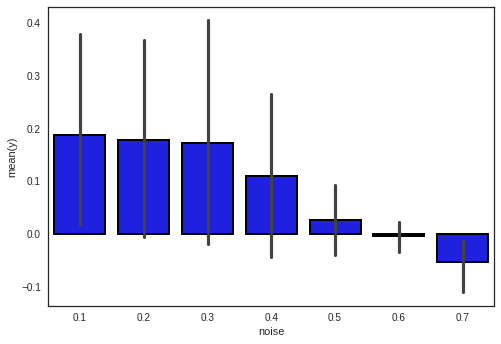

In [74]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
#df = df[df['nb_layers']==3]
df = df[df['noise']<=0.7]
ax = sns.barplot(                                                                                
    x='noise',                                                                                      
    y='y',                                                                           
    data=df,
    linewidth=2,
    color='blue',
    edgecolor=['black']*len(df),
)

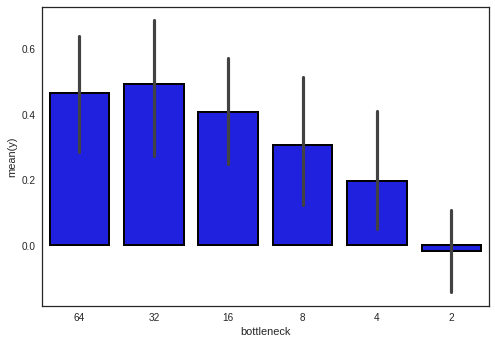

In [94]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
#df = df[df['nb_layers']==3]
ax = sns.barplot(                                                                                
    x='bottleneck',                                                                                      
    y='y',                                                                           
    data=df,
    order=[64, 32, 16, 8, 4, 2],
    linewidth=2,
    color='blue',
    edgecolor=['black']*6,
)
#show_several(df)

4af94c66522e14aa3b936f2fa6a43e6b


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


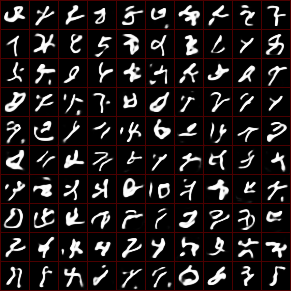

bd07e63bdfdcdef0811d9dd94230cd0d


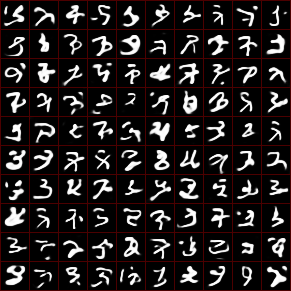

93796d92288367753127039b1bc8bb9f


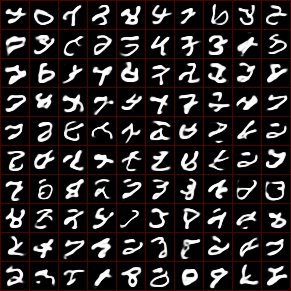

bb8051dece1c1d1c64b96ec2a6e53179


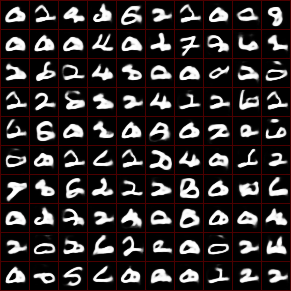

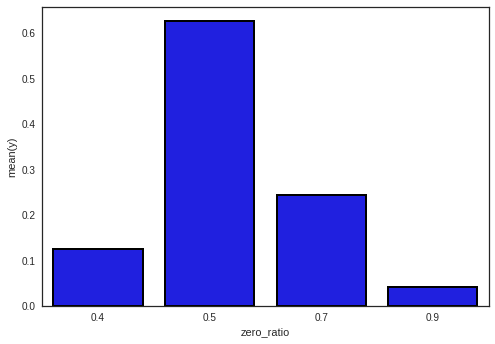

In [109]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']>=0.4]
df = df[df['nb_layers'] == 6]
ax = sns.barplot(                                                                                
    x='zero_ratio',                                                                                      
    y='y',                                                                           
    data=df,
    linewidth=2,
    color='blue',
    edgecolor=['black']*6,
)
show_several(df)

5511413bb44248b61f32518f638a8d9e


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


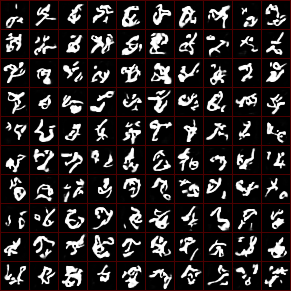

bb5d6a6de1dbd6dffbd0f0f6598ba299


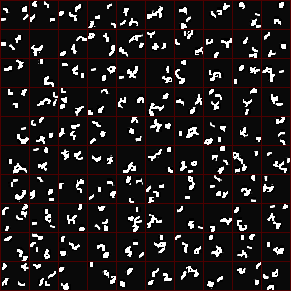

6bb78c372599de340e0d5cf8bc66c536


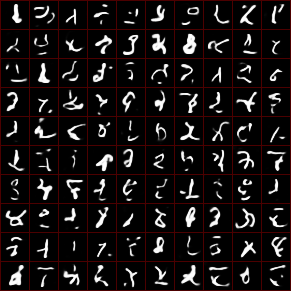

8de00294df9f7d4798acf058038c548c


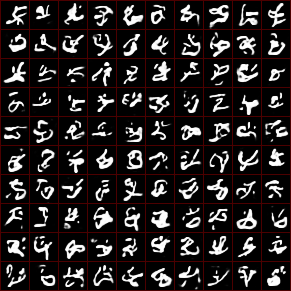

0c303e61d8760ad56cb5af9b28cd9649


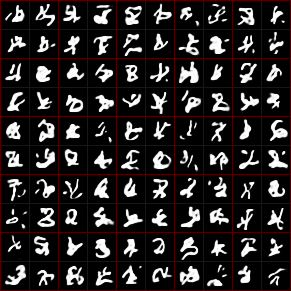

68d5ee04e4b8638c35f7024f07817250


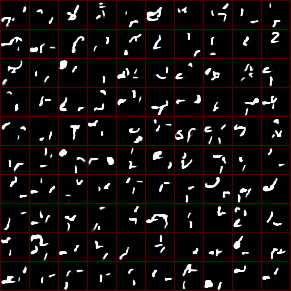

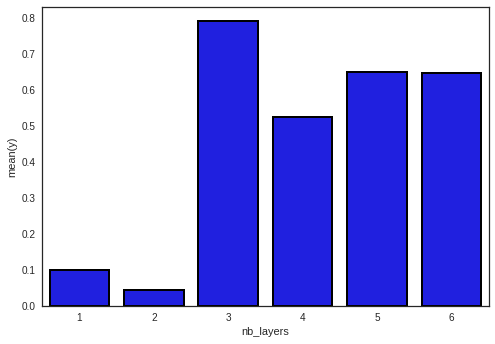

In [91]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==0]
ax = sns.barplot(                                                                                
    x='nb_layers',                                                                                      
    y='y',                                                                           
    data=df,
    linewidth=2,
    color='blue',
    edgecolor=['black']*6,
)
show_several(df)